In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [20]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

# Vanishing/Exploding Gradients Problem

Saving figure sigmoid_saturation_plot


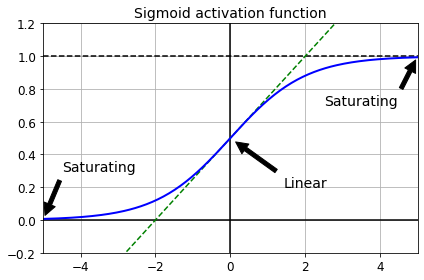

In [3]:
def logit(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

### Leaky ReLU

In [4]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


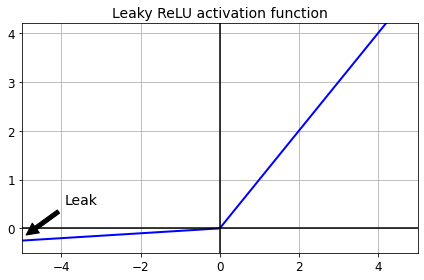

In [5]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

### ELU

In [6]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


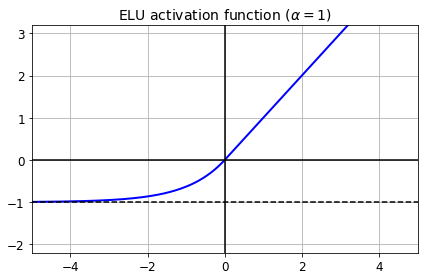

In [7]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

# Batch Normalization

In [8]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [10]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [11]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [12]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.8596 - accuracy: 0.7079 - val_loss: 0.5546 - val_accuracy: 0.8178
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5768 - accuracy: 0.8002 - val_loss: 0.4761 - val_accuracy: 0.8406
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5161 - accuracy: 0.8211 - val_loss: 0.4393 - val_accuracy: 0.8528
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4787 - accuracy: 0.8325 - val_loss: 0.4182 - val_accuracy: 0.8598
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4562 - accuracy: 0.8412 - val_loss: 0.4022 - val_accuracy: 0.8628
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4413 - accuracy: 0.8453 - val_loss: 0.3890 - val_accuracy: 0.8668
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4262 - accuracy: 0.8501 - val_loss: 0.3799 - val_accuracy

In [13]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [14]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [15]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 1.0478 - accuracy: 0.6734 - val_loss: 0.6777 - val_accuracy: 0.7874
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.6833 - accuracy: 0.7827 - val_loss: 0.5593 - val_accuracy: 0.8186
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5993 - accuracy: 0.8019 - val_loss: 0.5050 - val_accuracy: 0.8284
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5488 - accuracy: 0.8157 - val_loss: 0.4711 - val_accuracy: 0.8380
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5180 - accuracy: 0.8246 - val_loss: 0.4484 - val_accuracy: 0.8474
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4931 - accuracy: 0.8328 - val_loss: 0.4293 - val_accuracy: 0.8524
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4751 - accuracy: 0.8385 - val_loss: 0.4171 - val_accuracy

# Faster Optimizers

In [16]:
## Momentum optimization

optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

## Nesterov Accelerated Gradient

optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

## AdaGrad

optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

## RMSProp

optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

## Adam Optimization

optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Learning Rate Scheduling

### Power Scheduling

In [21]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [22]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [23]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4872 - accuracy: 0.8305 - val_loss: 0.4108 - val_accuracy: 0.8628
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3799 - accuracy: 0.8657 - val_loss: 0.3814 - val_accuracy: 0.8662
Epoch 3/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3472 - accuracy: 0.8769 - val_loss: 0.3644 - val_accuracy: 0.8732
Epoch 4/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3255 - accuracy: 0.8836 - val_loss: 0.3650 - val_accuracy: 0.8714
Epoch 5/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3098 - accuracy: 0.8907 - val_loss: 0.3498 - val_accuracy: 0.8778
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2967 - accuracy: 0.8945 - val_loss: 0.3459 - val_accuracy: 0.8790
Epoch 7/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2864 - accuracy: 0.8983 - val_loss: 0.3451 - val_accuracy:

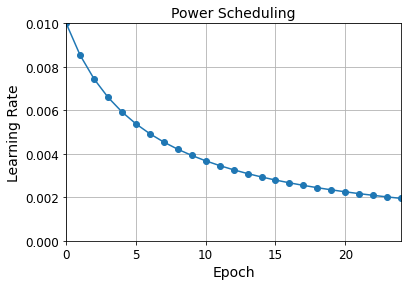

In [24]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

```lr = lr0 * 0.1**(epoch / s)```

In [25]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [26]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [27]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [28]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 12s 6ms/step - loss: 0.8895 - accuracy: 0.7464 - val_loss: 0.7039 - val_accuracy: 0.7848 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6942 - accuracy: 0.7900 - val_loss: 0.9086 - val_accuracy: 0.7510 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6451 - accuracy: 0.8102 - val_loss: 0.7552 - val_accuracy: 0.7882 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5501 - accuracy: 0.8306 - val_loss: 0.5410 - val_accuracy: 0.8422 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4894 - accuracy: 0.8464 - val_loss: 0.5471 - val_accuracy: 0.8258 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4532 - accuracy: 0.8571 - val_loss: 0.6067 - val_accuracy: 0.8128 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================

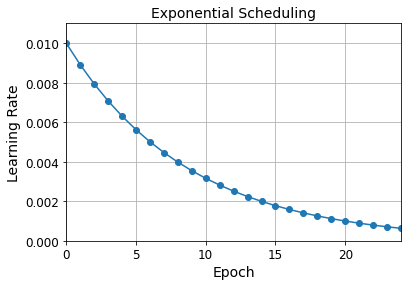

In [29]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [30]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [31]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        K.set_value(self.model.optimizer.learning_rate, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.8301 - accuracy: 0.7567 - val_loss: 0.7638 - val_accuracy: 0.7640 - lr: 0.0089
Epoch 2/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6722 - accuracy: 0.7908 - val_loss: 0.5840 - val_accuracy: 0.8200 - lr: 0.0079
Epoch 3/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5899 - accuracy: 0.8160 - val_loss: 0.6970 - val_accuracy: 0.7810 - lr: 0.0071
Epoch 4/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5105 - accuracy: 0.8392 - val_loss: 0.6338 - val_accuracy: 0.8118 - lr: 0.0063
Epoch 5/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4748 - accuracy: 0.8492 - val_loss: 0.4904 - val_accuracy: 0.8374 - lr: 0.0056
Epoch 6/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4370 - accuracy: 0.8619 - val_loss: 0.5497 - val_accuracy: 0.8486 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================

In [32]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

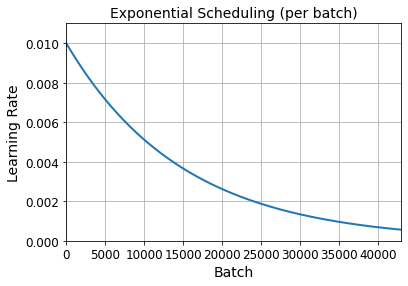

In [33]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

In [34]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [35]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [36]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.9283 - accuracy: 0.7332 - val_loss: 1.0807 - val_accuracy: 0.7340 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.9063 - accuracy: 0.7265 - val_loss: 1.6654 - val_accuracy: 0.6726 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.8816 - accuracy: 0.7455 - val_loss: 1.0171 - val_accuracy: 0.7062 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.8306 - accuracy: 0.7555 - val_loss: 0.7856 - val_accuracy: 0.7366 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.9894 - accuracy: 0.7100 - val_loss: 0.9523 - val_accuracy: 0.6818 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6136 - accuracy: 0.8104 - val_loss: 0.6559 - val_accuracy: 0.8250 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================

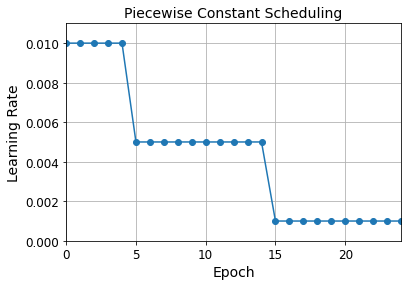

In [37]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [38]:
tf.random.set_seed(42)
np.random.seed(42)

In [39]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5967 - accuracy: 0.8060 - val_loss: 0.4719 - val_accuracy: 0.8472 - lr: 0.0200
Epoch 2/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5006 - accuracy: 0.8388 - val_loss: 0.5206 - val_accuracy: 0.8484 - lr: 0.0200
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5090 - accuracy: 0.8426 - val_loss: 0.5111 - val_accuracy: 0.8540 - lr: 0.0200
Epoch 4/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5106 - accuracy: 0.8474 - val_loss: 0.5150 - val_accuracy: 0.8488 - lr: 0.0200
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5229 - accuracy: 0.8489 - val_loss: 0.5246 - val_accuracy: 0.8594 - lr: 0.0200
Epoch 6/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5056 - accuracy: 0.8541 - val_loss: 0.6161 - val_accuracy: 0.8500 - lr: 0.0200
Epoch 7/25
1719/1719 [==============================] - 6s

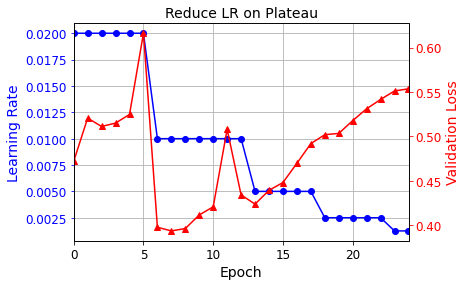

In [40]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [41]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [42]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 13s 7ms/step - loss: 1.5956 - accuracy: 0.8124 - val_loss: 0.7169 - val_accuracy: 0.8340
Epoch 2/2
1719/1719 [==============================] - 11s 6ms/step - loss: 0.7197 - accuracy: 0.8274 - val_loss: 0.6850 - val_accuracy: 0.8376


In [43]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 12s 7ms/step - loss: 1.6313 - accuracy: 0.8113 - val_loss: 0.7218 - val_accuracy: 0.8310
Epoch 2/2
1719/1719 [==============================] - 11s 6ms/step - loss: 0.7187 - accuracy: 0.8273 - val_loss: 0.6826 - val_accuracy: 0.8382


## Dropout

In [44]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5838 - accuracy: 0.7997 - val_loss: 0.3730 - val_accuracy: 0.8644
Epoch 2/2
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4209 - accuracy: 0.8443 - val_loss: 0.3397 - val_accuracy: 0.8716


## Max norm

In [45]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [46]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 14s 7ms/step - loss: 0.4777 - accuracy: 0.8334 - val_loss: 0.3677 - val_accuracy: 0.8694
Epoch 2/2
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3520 - accuracy: 0.8720 - val_loss: 0.3729 - val_accuracy: 0.8636
